Séries temporais com machine learning <br>
Análise de CSV contendo o histórico de vendas de álcool

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg

Upload CSV

In [2]:
data = pd.read_csv('./Alcohol_Sales.csv', delimiter=',')
data

,DATE,S4248SM144NCEN
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221
...,...,...
320,2018-09-01,12396
321,2018-10-01,13914
322,2018-11-01,14174
323,2018-12-01,15504


Tratamento dos dados

In [3]:
data = data.rename(columns={'S4248SM144NCEN': 'SALES'})
data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m-%d')
data = data.set_index('DATE')
data = data.sort_index()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 325 entries, 1992-01-01 to 2019-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   SALES   325 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB


Plotagem de dados

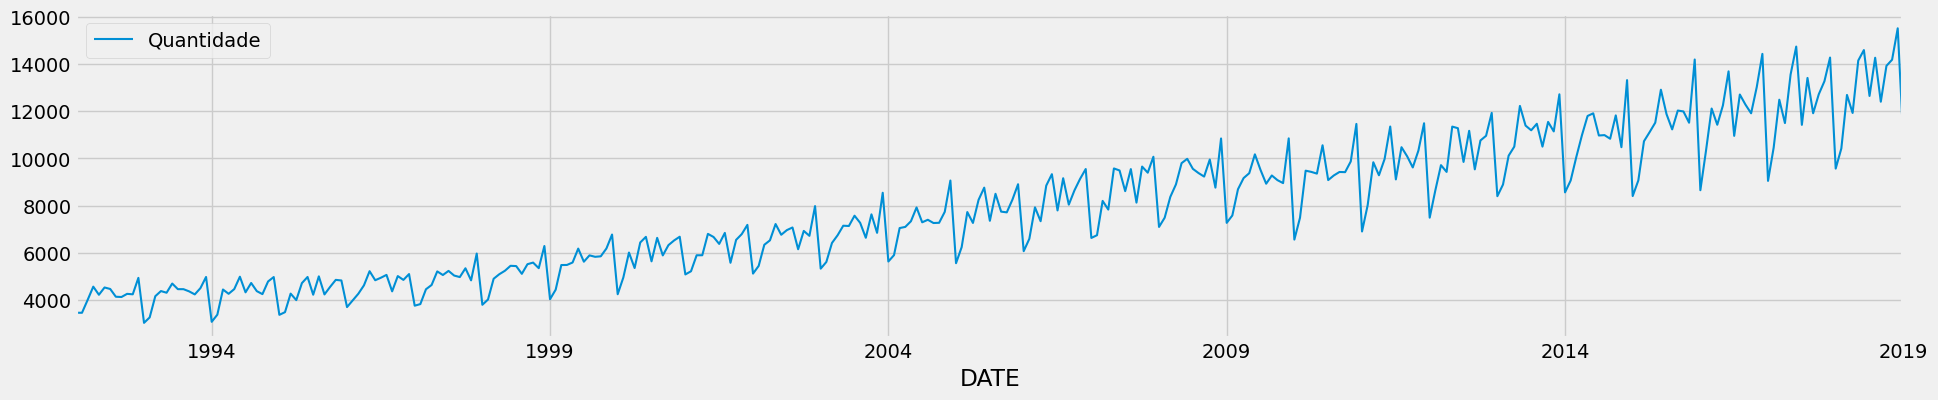

In [4]:
fig, ax = plt.subplots(figsize=(21, 4))
data['SALES'].plot(ax=ax, label='Quantidade')
ax.legend()

In [5]:
print(f'Linhas com valores nulos: {data.isnull().any(axis=1).mean()}')

Linhas com valores nulos: 0.0


In [6]:
data = data.asfreq('MS', fill_value=0.0)
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

Divisão de treinamento e teste

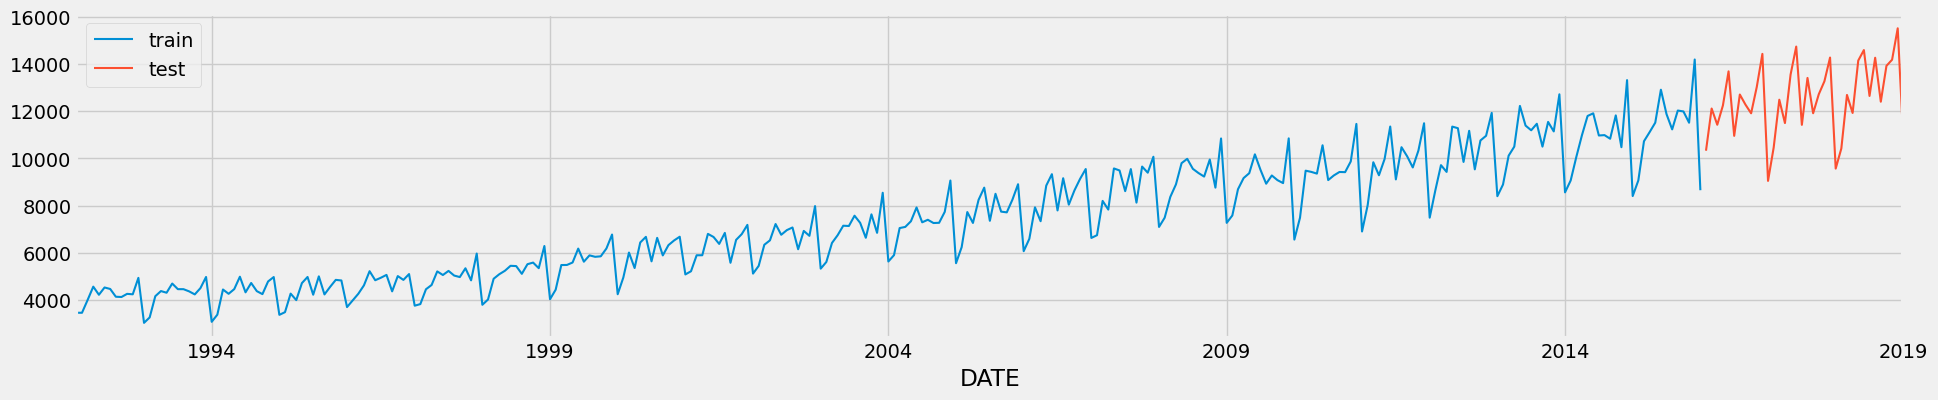

In [7]:
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

fig, ax=plt.subplots(figsize=(21, 4))
data_train['SALES'].plot(ax=ax, label='train')
data_test['SALES'].plot(ax=ax, label='test')
ax.legend()

RandomForestRegressor

In [8]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(max_depth=10, n_estimators=50, random_state=123),
                lags      = 12
             )

forecaster.fit(y=data_train['SALES'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=10, n_estimators=50, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-01-01 00:00:00'), Timestamp('2016-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-05-30 17:17:45 
Last

Predição do conjunto de teste

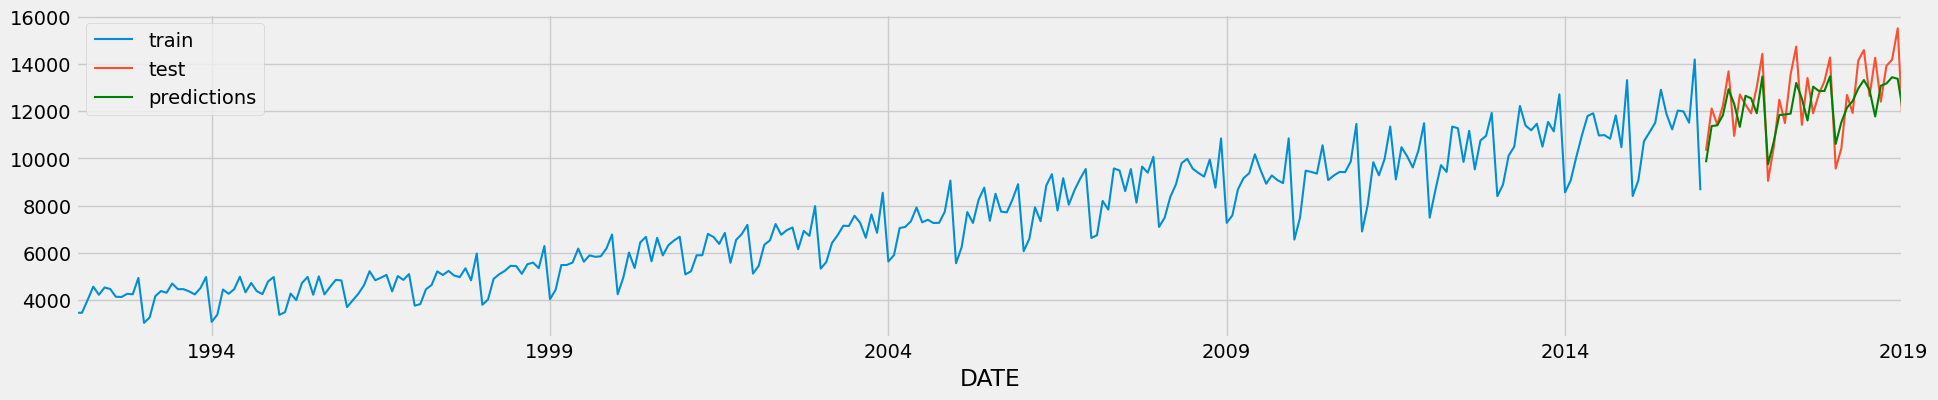

In [9]:
steps = 36
predictions = forecaster.predict(steps=steps)

fig, ax=plt.subplots(figsize=(21, 4))
data_train['SALES'].plot(ax=ax, label='train')
data_test['SALES'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions', color='green')
ax.legend()

Tunning

In [10]:
from skforecast.model_selection import grid_search_forecaster

steps = 36
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 12
             )

lags_grid = [10, 15, 20]
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [3, 5, 10, 15]
}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data_train['SALES'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = steps,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = int(len(data_train)*0.5),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )

c:\Users\Igor\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of models compared: 60.


lags grid: 100%|██████████| 3/3 [00:56<00:00, 18.91s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 4096035.0620961287



Realizar novamente o treino e predição

In [11]:
regressor = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=123)
forecaster = ForecasterAutoreg(
                 regressor = regressor,
                 lags      = 20
             )
forecaster.fit(y=data_train['SALES'])

In [12]:
predictions = forecaster.predict(steps=steps)

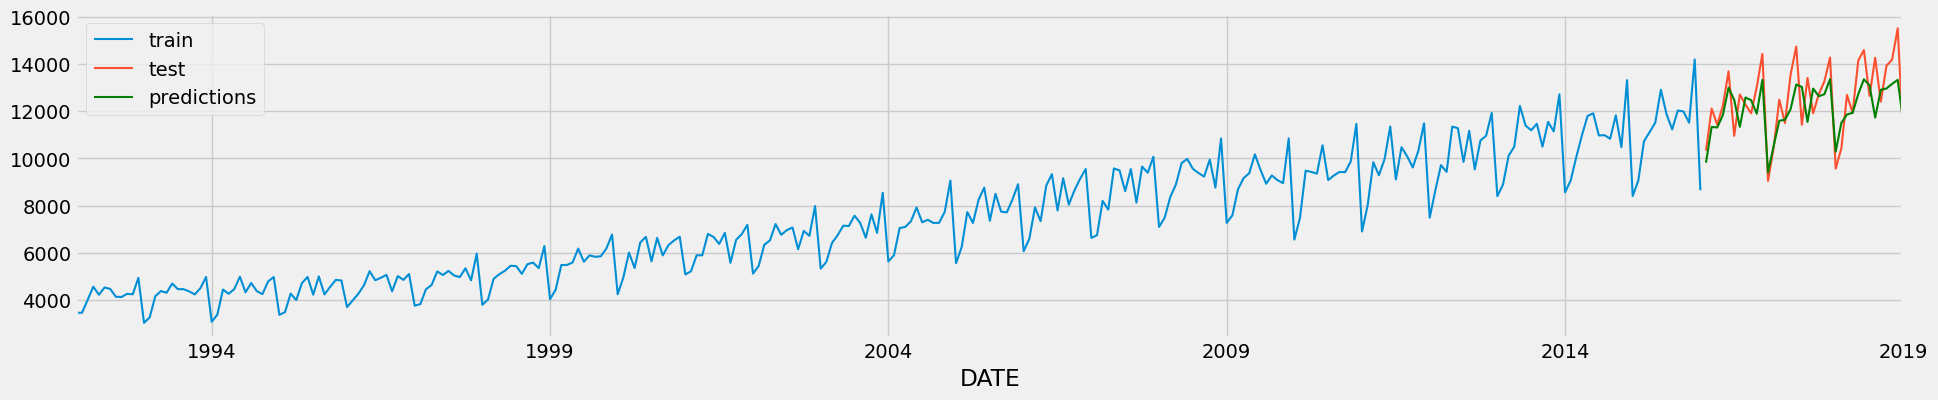

In [13]:
fig, ax = plt.subplots(figsize=(21, 4))
data_train['SALES'].plot(ax=ax, label='train')
data_test['SALES'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions', color='green')
ax.legend()